<img src="dolan_logo.png" alt="Drawing" style="width: 200px;"/>

# Advanced Preparation of Financial Data

An IPO is an (Initial Public Offering). It is the first opportunity for a private company to sell stock in their company publicly. Companies do this so they can raise money in their company. 

Typically, a company going through the IPO process hires an underwriter, usually an investment bank, who helps them with pricing their company. 

Because the company is so new and exclusive, IPOs typically attract a lot of attention when they hit the market. They are typically pretty risky and volatile investments, since the historical pricing data is not there, so it is difficult to predict where the price will go. In finance, there is usually a tradeoff between risk and return. With that said, investors will invest in riskier IPOs hoping for a big potential return. 

So with all this being said, we are lucky to have obtained data from over 600 firms that our client is seeking analysis around. In our data we have 22 features to test around to see what are the determinants of IPO underpricing phenomena.

# Project Overview

<img src="project_layout_new.png" alt="Drawing" style="width: 500px;"/>

As shown above, our analysis took the form of standard steps at the beginning and end, with two different pipelines in the middle. In this manner, we can ensure that the early data preperation and final modeling preperation are standardized, but that we also have an opportunity to see if different techniques are more effective such as earlier normalization rather than towards the end of our data prep.

As we expect our target variables to be difficult to predict, we chose to combine the features from both pipelines and allow feature selection to choose the best features. Certain variables may have more predictive power coming from Pipeline A as opposed to Pipeline B. By including both sets we have more options and, hopefully, better predictions.

# Initial Step: Imports and loading data

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import chain
import xgboost
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import f1_score
import pickle 

pd.set_option('display.max_columns', 500)

In [2]:
# Load the raw data and create a copy to use
raw_data = pd.read_excel('Competition1_raw_data.xlsx')
data = raw_data.copy()

We can take an initial look at the data to start planning our strategy. This can be done both by looking at the first few rows of the data, as well as leverging the data dictionary.

In [3]:
# Look at the initial data
data.head()

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10,9.5,8.5,11.87,122,1,3.43,0.0290743,40962052,10600000,51.345,470,12719,11560,301,690,62,117,139
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8,10,8,7.25,259,0,-1.62,-0.0133516,28869196,2400000,25.936,791,21792,19585,510,1120,71,242,237
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7,14,12,6.7,90,1,-1.24,0.020715,16845668,5000000,7.378,201,5262,4785,128,325,61,33,60
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,11.5,16,14,12.39,209,1,-0.91,0.0200231,14848637,4500000,8.526,328,8259,7574,177,509,80,59,110
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,21,21,19,56.6,80,1,0.07,-0.0348947,30741716,8250000,632.298,572,14830,13176,336,720,67,149,167


![title](data_dict.png)

# Step 1: Identify the null values

As given, the data identifies some null values with the '-' symbol. Replacing these with actual null values will allow handling them to be easier.

In [4]:
# Replace the '-' indicator with nulls
for col in data.columns:
    data[col] = data[col].apply(lambda x: np.nan if x == '-' else x)

Null values have been updated to more easily identifiable. However, there are scenarios which logically do not make as much sense. These can be identified and then replaced with null values so we can impute them at a later time. These scenarios include the following:

 - Quoted price range for IPO wherein higher price is lower than the lower price
 - Number of long sentences are less than the number of sentences
 - Number of words are less than the number of real words
 - Number of long words less than number of real words
 - Number of words less than number of sentences
 
There are certain scenarios, such as P(L) being higher than P(H) when the values can potentially be swapped to infer the intent behind the data and "fix" its integrity. However, there is always a chance that this introduces additional error as we are not familiar with how the data was procurred. For this and other scenarios, setting these values to null and handling through imputation seemed the more reliable strategy.

In [5]:
def data_validation(row):  
    '''
    Run initially to identify rows which do not logically make sense.
    Fix the issues, and then rerun until only nulls left
    
    '''
    # If any nulls we know it's off
    ret_val = 0
    if row.isna().any():
        ret_val = 1
    
    # P(H) > P(L)
    #Higher range of price > lower range
    if row['P(H)'] < row['P(L)']:
        ret_val = 2
    
    # T4 < T1
    # Number of long sentences less than number of sentences
    elif row['T4'] > row['T1']:
        ret_val = 3
        
    # T3 < T2
    # Number of words < number of real words
    elif row['T3'] > row['T2']:
        ret_val = 4
        
    # T5 < T2
    # Number of long words < number of total words
    elif row['T5'] > row['T2']:
        ret_val = 5
        
    # T1 < T2
    # Number of words > number of sentences
    elif row['T1'] > row['T2']:
        ret_val = 6
    
    # C2, C3' in [0,1]
    # Defined as only being one of these two
    elif row['C2'] not in [0.0,1.0] and pd.notnull(row['C2']):
        ret_val = 7
    
    return ret_val
    

In [6]:
# Create a seperate field which indicates that the row, at some point, contained null values which needed to be imputed
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [7]:
data.data_updated.value_counts()

0    590
1     87
4      2
2      2
3      1
Name: data_updated, dtype: int64

We can see that there are 87 rows containing null values. Additionally, a few rows contain logic which does not make sense. We can fix those now, rerun, and check that all rows do not have logical flaws. 

In [8]:
data.loc[data['data_updated'] == 2, ['P(H)','P(L)']] = np.nan
data.loc[data['data_updated'] == 3, ['T4','T1']] = np.nan
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [9]:
data.data_updated.value_counts()

0    590
1     91
4      1
Name: data_updated, dtype: int64

A single row had more than one logical issue. We can fix this, and run or identification function again to ensure all rows have been cleaned.

In [10]:
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)
data.data_updated.value_counts()

0    590
1     92
Name: data_updated, dtype: int64

Now the only issue left is the null values which we can address through imputation.

# Step 2: Descriptive Statistics
- Mean/median/std/min/max/count/quartiles
- Missing Records
- Outlier Identification
    - Address Outliers
- Data Types/Fix data types

The describe method can give a lot of useful information about each of the column values including quartile information, the mean, minimum and maximum values, and the standard deviation.

In [11]:
data.describe()

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
count,677.000000,670.000000,670.000000,660.000000,660.000000,660.000000,646.000000,660.000000,6.760000e+02,6.760000e+02,610.000000,680.000000,678.000000,678.000000,680.000000,681.000000,681.000000,681.000000,681.000000,682.000000
mean,13.837666,15.522925,13.527030,25.934766,149.728788,0.859091,1.788904,0.007282,4.935776e+07,1.241519e+07,500.459962,465.957353,12814.283186,11377.873156,294.264706,679.220264,68.421439,120.104258,144.759178,0.134897
std,6.053731,6.618732,5.839649,73.234948,152.817467,0.348192,162.666532,0.033318,1.043764e+08,2.512855e+07,1648.337634,175.668619,5396.780570,4833.321230,121.599795,472.914323,39.096525,84.828959,69.276285,0.341865
min,3.000000,4.000000,3.000000,0.000000,10.000000,0.000000,-786.239000,-0.162352,3.693227e+06,5.250000e+05,0.074000,132.000000,3271.000000,0.000000,0.000000,-1.000000,-1.000000,20.000000,26.000000,0.000000
25%,10.000000,13.000000,11.000000,11.000000,85.000000,1.000000,-0.852500,-0.013927,1.871417e+07,5.000000e+06,37.245750,351.750000,9213.250000,8135.000000,212.750000,462.000000,45.000000,73.000000,100.000000,0.000000
50%,13.500000,15.000000,13.000000,14.845000,107.000000,1.000000,0.010000,0.009125,2.740018e+07,7.398704e+06,103.833000,444.500000,12056.000000,10774.500000,279.000000,624.000000,60.000000,100.000000,134.000000,0.000000
75%,17.000000,17.000000,15.000000,20.485000,155.250000,1.000000,0.470000,0.031571,4.980786e+07,1.200000e+07,331.138000,551.250000,15243.250000,13712.000000,353.250000,795.000000,85.000000,142.000000,173.000000,0.000000
max,85.000000,135.000000,108.000000,1159.200562,2087.000000,1.000000,3864.500000,0.092896,2.138085e+09,4.212336e+08,30683.000000,1750.000000,49056.000000,43952.000000,1058.000000,10277.000000,309.000000,944.000000,883.000000,1.000000


The dataframe above provides several interesting bits of information. To begin with, the min and max fields for each column show that many columns have dramatically different ranges, and therefore cannot be compared in a one-to-one manner as they are on a different scale, in different units. This introduces the need for scaling the data so that it can actually be compared in this manner.

Additionally, the count of each field can be used to explore the columns containing the most null values. The lowest count of 610 implies that the field C7 contains the most null values and will need the most imputation. Due to the clear amount of null values, imputation will need to be explored in depth.

In [12]:
pd.isna(data).sum()

I1               0
I2               0
I3               8
P(IPO)           5
P(H)            12
P(L)            12
P(1Day)         22
C1              22
C2              22
C3              36
C4              22
C5               6
C6               6
C7              72
T1               2
T2               4
T3               4
T4               2
T5               1
S1               1
S2               1
S3               1
data_updated     0
dtype: int64

As noticed above, C7 contains the most null values. However, it is easier to view in this format, and also shows that many other fields contain a fair amount of null values.

To continue our data exploration we can view the data types present in our data. We expect most to be numeric, either float or ints, with the exception of the first two columns.

In [13]:
data.dtypes

I1               object
I2               object
I3               object
P(IPO)          float64
P(H)            float64
P(L)            float64
P(1Day)         float64
C1              float64
C2              float64
C3              float64
C4              float64
C5              float64
C6              float64
C7              float64
T1              float64
T2              float64
T3              float64
T4              float64
T5              float64
S1              float64
S2              float64
S3              float64
data_updated      int64
dtype: object

Strangely, the data type of I3 appears to be an object. In taking a closer look we can see several rows have string representation of lists of integers rather than a single integer. In checking for those which are string we can view the four objects which need to be updated for the column to be represented in the correct manner.

In [14]:
data[data.I3.apply(lambda x: isinstance(x, str))]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
174,DLB,"Dolby Laboratories, Inc.","6794, 3861, 3663, 7819",18.0,18.0,16.0,24.299999,90.0,1.0,0.47,0.020090,97362135.0,27500000.0,289.041,500.0,15288.0,14243.0,360.0,912.0,69.0,122.0,165.0,0
187,DTSI,"DTS, INC.","3651, 6794, 7819",17.0,16.0,14.0,24.920000,76.0,0.0,0.99,0.044011,13097313.0,3840000.0,41.056,339.0,8274.0,7487.0,204.0,421.0,49.0,95.0,70.0,0
499,RLD,RealD Inc.,"3663, 3861, 6794",16.0,15.0,13.0,19.510000,98.0,1.0,-0.33,0.012058,47638374.0,12500000.0,39.675,629.0,15904.0,14741.0,364.0,899.0,104.0,139.0,227.0,0
620,UPG,UNIVERSAL POWER GROUP,"7389, 5063",7.0,9.0,7.0,7.350000,101.0,0.0,0.38,-0.000171,5000000.0,3000000.0,81.275,304.0,6904.0,6234.0,147.0,287.0,29.0,61.0,66.0,0


The column I3 refers to the SIC code value associated with a company. As these companies have more than one we can use the following chart to see if any of the rows with more than one SIC code have a natural grouping in their values. 

<table class="wikitable sortable jquery-tablesorter">

<thead><tr>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Range of SIC Codes
</th>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Division
</th></tr></thead><tbody>
<tr>
<td>0100-0999
</td>
<td>Agriculture, Forestry and Fishing
</td></tr>
<tr>
<td>1000-1499
</td>
<td>Mining
</td></tr>
<tr>
<td>1500-1799
</td>
<td>Construction
</td></tr>
<tr>
<td>1800-1999
</td>
<td>not used
</td></tr>
<tr>
<td>2000-3999
</td>
<td>Manufacturing
</td></tr>
<tr>
<td>4000-4999
</td>
<td>Transportation, Communications, Electric, Gas and Sanitary service
</td></tr>
<tr>
<td>5000-5199
</td>
<td>Wholesale Trade
</td></tr>
<tr>
<td>5200-5999
</td>
<td>Retail Trade
</td></tr>
<tr>
<td>6000-6799
</td>
<td>Finance, Insurance and Real Estate
</td></tr>
<tr>
<td>7000-8999
</td>
<td>Services
</td></tr>
<tr>
<td>9100-9729
</td>
<td>Public Administration
</td></tr>
<tr>
<td>9900-9999
</td>
<td>Nonclassifiable
</td></tr></tbody><tfoot></tfoot></table>

Both Dolby Laboratories Inc. and RealD Inc. have some semblence of agreement in the SIC codes indicating mostly Manufacturing content. In order to represent this, these two rows will have their I3 column assigned to a value in the Manufacturing range.

The other two rows do not have the same SIC code overlap and will be set as a code in the "Nonclassifiable" range to avoid making assumptions.

In [15]:
data.loc[174, ['I3']] = 3500
data.loc[499, ['I3']] = 3500

data.loc[187, ['I3']] = 9999
data.loc[620, ['I3']] = 9999

We can now check again to be sure we no longer have string fields for this column.

In [16]:
data[data.I3.apply(lambda x: isinstance(x, str))]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated


Now that this has been handled, this field can be read as a a float64 field as originally intended and similar to the other fields.

In [17]:
data['I3'] = data['I3'].astype(np.float64)

With our data types handled appropriately, we can begin trying to obtain more useful information about the data. We will start by looking at the distribution of each continuous field.

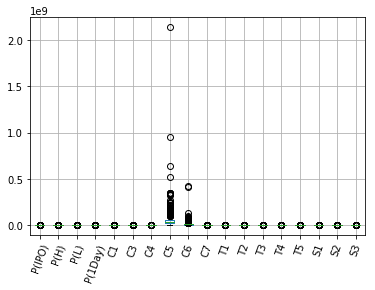

In [18]:
data[[i for i in data.columns if i not in ['I1','I2','I3', 'C2', 'data_updated']]].boxplot(rot=70)
plt.show()

This chart is not very useful as the scale is dramatically different based on the column in question. In order to properly view each of these fields we will add a scaler to bring the data within the range of 0 and 1.

In [19]:
def min_max_scale_col(df, cols):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(new_df[cols])

def min_max_scale_df(df):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(df)

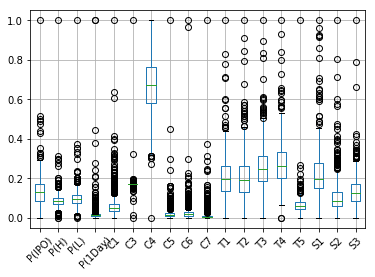

In [20]:
hold_scaled = pd.DataFrame(min_max_scale_df(data[[i for i in data.columns if i not in ['I1','I2','I3', 'C2', 'data_updated']]]))
hold_scaled.columns = [i for i in data.columns if i not in ['I1','I2','I3', 'C2', 'data_updated']]
hold_scaled.boxplot(rot=45)
plt.show()

The scaled data allows all the fields to be viewed at once. This new representation appears to show that there are many outliers which will need to be dealt with at a later point.

Additionally, the fields which will be leveraged to create our target variables also appear to have a drastic range. This implies that predicting our target variable will most likely be difficult given the data distribution.

# Step 3: Data Imputation
- Address null values dependent on the type of value in question
- Create a seperate column which shows whether or not imputation occurred

Imputation is the process of replacing missing data with substituted values. Typically the mean, median, or mode values are used to replace the missing data.

In [21]:
def impute_nulls_df(df, col, replace_val):
    '''
    params:
    
    df - dataframe containing nulls
    col - columns with nulls to replace
    replace_val - options: 'mean', 'median', 'mode'
    
    Example:

    imputed_data = impute_nulls(data, C1, 'mean')
    '''
    
    if replace_val not in ['mean','median','mode']:
        print('requires one of the following: mean, median, mode')
        return
    
    elif replace_val == 'mean':
        df[col + '_imputed'] = df[col].fillna(df[col].mean())
    elif replace_val == 'median':
        df[col + '_imputed'] = df[col].fillna(df[col].median())
    elif replace_val == 'mode':
        df[col + '_imputed'] = df[col].fillna(df[col].mode().values[0])
        
    return df

In order to do imputation in a more consistant manner we will create a dictionary containing each column and the type of imputation to be leveraged. Each field can then be imputed at the same time. 

In [22]:
null_cols = pd.isna(data).sum()
null_cols = null_cols[null_cols.values != 0]
null_cols

I3          8
P(IPO)      5
P(H)       12
P(L)       12
P(1Day)    22
C1         22
C2         22
C3         36
C4         22
C5          6
C6          6
C7         72
T1          2
T2          4
T3          4
T4          2
T5          1
S1          1
S2          1
S3          1
dtype: int64

Before imputation, certain rows should be dropped. All fields leading with 'P' are needed for creating our target variables. Dropping those with null values for these columns is acceptable

In [23]:
data = data[(~pd.isna(data['P(IPO)'])) & (~pd.isna(data['P(H)'])) & (~pd.isna(data['P(L)'])) & (~pd.isna(data['P(1Day)']))]

In [24]:
null_cols = pd.isna(data).sum()
null_cols = null_cols[null_cols.values != 0]
null_cols

C3    23
C7    60
T2     2
T3     2
dtype: int64

It appears that the items with null fields needed for the target variable constituted much of the null values across other columns. We now only need imputation for four fields.

In order to correctly impute the data we will create histograms and review the boxplots to get a better view of the correct imputation strategy for each field.

For histograms, the mean will be identified by a red line, and the median by one which is green.

/opt/tljh/user/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


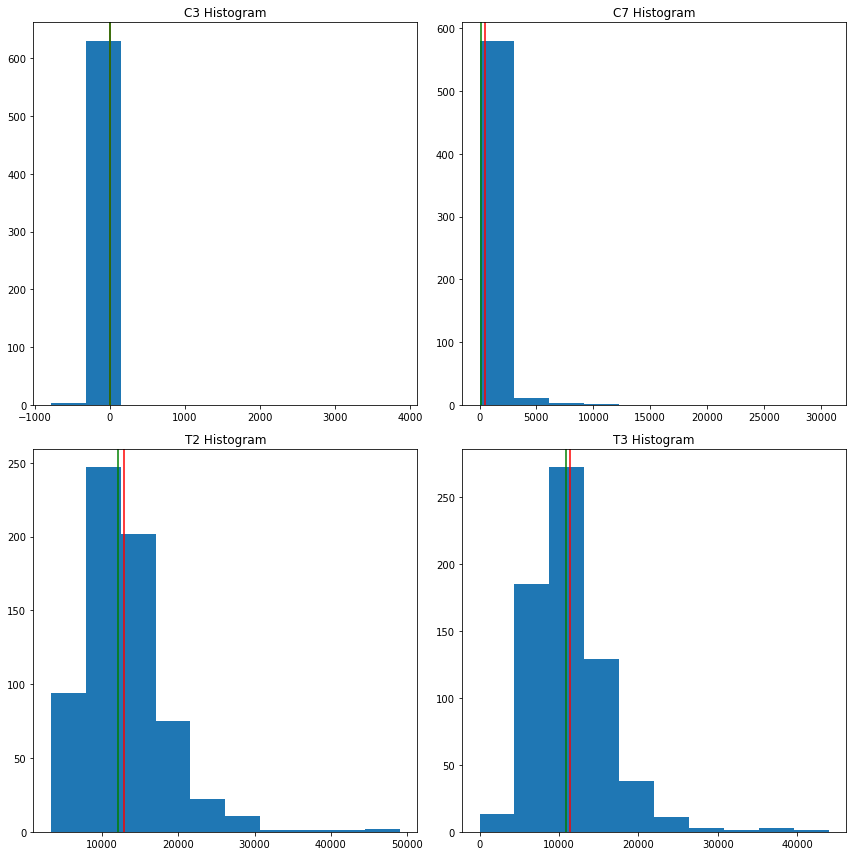

In [25]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12,12))

x1 = data['C3'].dropna()
x2 = data['C7'].dropna()
x3 = data['T2'].dropna()
x4 = data['T3'].dropna()

axs[0,0].hist(x1)
axs[0,0].axvline(x1.mean(), color = 'red')
axs[0,0].axvline(x1.median(), color = 'green')
axs[0,0].set_title('C3 Histogram')

axs[0,1].hist(x2)
axs[0,1].axvline(x2.mean(), color = 'red')
axs[0,1].axvline(x2.median(), color = 'green')
axs[0,1].set_title('C7 Histogram')

axs[1,0].hist(x3)
axs[1,0].axvline(x3.mean(), color = 'red')
axs[1,0].axvline(x3.median(), color = 'green')
axs[1,0].set_title('T2 Histogram')

axs[1,1].hist(x4)
axs[1,1].axvline(x4.mean(), color = 'red')
axs[1,1].axvline(x4.median(), color = 'green')
axs[1,1].set_title('T3 Histogram')

plt.show()

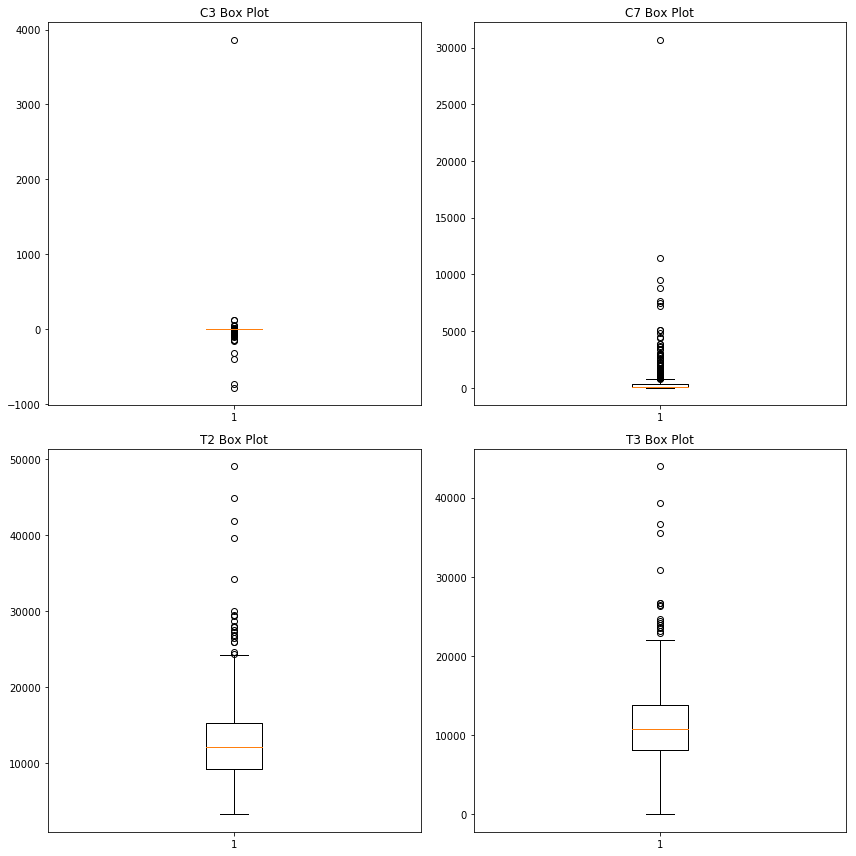

In [26]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12,12))

axs[0,0].boxplot(x1)
axs[0,0].set_title('C3 Box Plot')

axs[0,1].boxplot(x2)
axs[0,1].set_title('C7 Box Plot')

axs[1,0].boxplot(x3)
axs[1,0].set_title('T2 Box Plot')

axs[1,1].boxplot(x4)
axs[1,1].set_title('T3 Box Plot')

plt.show()

The difference between mean and median appears to be small in the histograms, but the amount of outliers seen in the boxplots makes median a safer method for imputation for each of these fields.

In [27]:
# There are a lot of heavy outliers in the dataset, so median is used for many imputations

imputing = {
    'C3': 'median',
    'C7': 'median',
    'T2': 'median',
    'T3': 'median'
 }

data_w_imputed = data.copy()

for key in imputing.keys():
    data_w_imputed = impute_nulls_df(data_w_imputed, key, imputing[key])

Let's check to ensure that only the original four columns have null values and the imputed ones have none.

In [28]:
pd.isna(data_w_imputed).sum()

I1               0
I2               0
I3               0
P(IPO)           0
P(H)             0
P(L)             0
P(1Day)          0
C1               0
C2               0
C3              23
C4               0
C5               0
C6               0
C7              60
T1               0
T2               2
T3               2
T4               0
T5               0
S1               0
S2               0
S3               0
data_updated     0
C3_imputed       0
C7_imputed       0
T2_imputed       0
T3_imputed       0
dtype: int64

Imputation appears sucessful so the original columns can be dropped.

In [29]:
data_w_imputed = data_w_imputed.drop(columns=['C3','C7','T2','T3'])

# Step 3B: Seperate Categorical and Continuous Fields

The categorical and continuous fields will be seperated into seperate DataFrames. Both will retain the I1 field as a means of re-joining the data at a later time.

In [30]:
cat_fields = ['I1','I2', 'I3','C2','data_updated']
cat_data = data_w_imputed[cat_fields]

In [31]:
cont_data = data_w_imputed[['I1'] + list(set(data_w_imputed.columns) - set(cat_data.columns))]

# Step 4: Create values outlined in Data Dictionary
- T1-T5 as ratios
- S1-S3 as ratios
- C3', C5', C6'
- Y1, Y2
- Any additional that seem reasonable

Reference here: https://github.com/fairfield-university-ba545/project1-archana-s-team/blob/master/DataDictionary20190115.pdf

All the textual content describing word and sentence counts will be recreated as ratios to show the relative prevalance of each component piece.

In [32]:
# Example Ratio, divide the column with the number of words and columns with number of sentences to get words per sentence
cont_data['words_per_sentence'] = cont_data.T2_imputed / cont_data.T1
cont_data['real_word_per'] = cont_data.T3_imputed / cont_data.T2_imputed
cont_data['non_real_word_per'] = (cont_data.T2_imputed - cont_data.T3_imputed) / cont_data.T2_imputed
cont_data['short_sentences'] = cont_data.T1 - cont_data.T4
cont_data['short_sentences_per'] = cont_data.short_sentences / cont_data.T1
cont_data['long_sentences_per'] = cont_data.T4 / cont_data.T1
cont_data['long_words_per'] = cont_data.T5 / cont_data.T2_imputed

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [33]:
# Percentage of positive words by dividing count of positive words by total words
cont_data['pos_words_percent'] = cont_data.S1 / (cont_data.S1 + cont_data.S2 + cont_data.S3)
cont_data['neg_words_percent'] = cont_data.S2 / (cont_data.S1 + cont_data.S2 + cont_data.S3)
cont_data['uncertain_words_percent'] = cont_data.S3 / (cont_data.S1 + cont_data.S2 + cont_data.S3)

In [34]:
cont_data['total_shares'] = cont_data.C5 + cont_data.C6
cont_data['sales_per_share'] = cont_data.C7_imputed/cont_data.total_shares
cont_data['outstanding_share_per'] = cont_data.C5/cont_data.total_shares
cont_data['offering_share_per'] = cont_data.C6/cont_data.total_shares

The following will be leveraged for target calculation as well as other control variables.

![title](target_desc.png)

In [35]:
cont_data['C3_prime'] = cont_data.C3_imputed.apply(lambda x: 1 if x>0 else 0)
cont_data['C5_prime'] = cont_data['C5']/ cont_data['C6']
cont_data['P(mid)'] = (cont_data['P(H)'] + cont_data['P(L)'])/2
cont_data['C6_prime'] = (cont_data['P(IPO)'] - cont_data['P(mid)'])/cont_data['P(mid)']*100
cont_data['Y1'] = cont_data.apply(lambda row: 1 if row['P(IPO)'] < row['P(mid)'] else 0, axis = 1)
cont_data['Y2'] = cont_data.apply(lambda row: 1 if row['P(IPO)'] < row['P(1Day)'] else 0, axis = 1)

The I3 field contains dozens of different categories. Rather than leveraging these in their current state, they will be binned based on SIC code classification.

In [36]:
def bin_sic(val):
    try:
        val = int(val)
    except Exception as e:
        return 'Other'
    if val <= 999:
        return 'Agriculture, Forestry and Fishing'
    if val <= 1499:
        return 'Mining'
    if val <= 1799:
        return 'Construction'
    if val <= 1999:
        return 'Other'
    if val <= 3999:
        return 'Manufacturing'
    if val <= 4999:
        return 'Transportation, Communications, Electric, Gas and Sanitary service'
    if val <= 5199:
        return 'Wholesale Trade'
    if val <= 5999:
        return 'Retail Trade'
    if val <= 6799:
        return 'Finance, Insurance and Real Estate'
    if val <= 8999:
        return 'Services'
    if val <= 9729:
        return 'Public Administration'
    return 'Other'
    

In [37]:
cat_data['industry_bin'] = cat_data['I3'].apply(bin_sic)
cat_data['industry_bin'] = cat_data['industry_bin'].astype('category')
cat_data['C3_prime'] = cont_data['C3_prime']

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Now that the target variables have been created, a seperate DataFrame has been created to hold this information.

In [38]:
target_df = cont_data[['I1','Y1','Y2']]

Drop all fields used in creating additional fields.

In [39]:
continuous_df = cont_data.copy()
continuous_df = continuous_df.drop(columns = ['S1','S2','S3','T1','T2_imputed','T3_imputed',
                                              'T4','T5', 'P(IPO)', 'P(L)', 'P(H)', 'P(1Day)', 'P(mid)',
                                             'C5','C6','C3_prime', 'Y1','Y2'])
continuous_df.head()

,I1,C7_imputed,C3_imputed,C1,C4,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime
0,AATI,51.345,3.43,122.0,0.029074,27.061702,0.908876,0.091124,169.0,0.359574,0.640426,0.054250,0.194969,0.367925,0.437107,51562052.0,9.957905e-07,0.794422,0.205578,3.864345,11.111111
1,ABPI,25.936,-1.62,259.0,-0.013352,27.549937,0.898724,0.101276,281.0,0.355247,0.644753,0.051395,0.129091,0.440000,0.430909,31269196.0,8.294425e-07,0.923247,0.076753,12.028832,-11.111111
2,ACAD,7.378,-1.24,90.0,0.020715,26.179104,0.909350,0.090650,73.0,0.363184,0.636816,0.061764,0.396104,0.214286,0.389610,21845668.0,3.377329e-07,0.771122,0.228878,3.369134,-46.153846
3,ACHN,8.526,-0.91,209.0,0.020023,25.179878,0.917060,0.082940,151.0,0.460366,0.539634,0.061630,0.321285,0.236948,0.441767,19348637.0,4.406512e-07,0.767425,0.232575,3.299697,-23.333333
4,ACLI,632.298,0.07,80.0,-0.034895,25.926573,0.888469,0.111531,236.0,0.412587,0.587413,0.048550,0.174935,0.389034,0.436031,38991716.0,1.621621e-05,0.788417,0.211583,3.726269,5.000000


In [40]:
categorical_df = cat_data.copy()
categorical_df = categorical_df.drop(columns = ['I3','I2'])
categorical_df.head()

,I1,C2,data_updated,industry_bin,C3_prime
0,AATI,1.0,0,Manufacturing,1
1,ABPI,0.0,0,Manufacturing,0
2,ACAD,1.0,0,Manufacturing,0
3,ACHN,1.0,0,Manufacturing,0
4,ACLI,1.0,0,"Transportation, Communications, Electric, Gas ...",1


Save categorical and continuous DFs

In [41]:
categorical_df.to_csv('categorical_df.csv')
continuous_df.to_csv('continuous_df.csv')
target_df.to_csv('target_df.csv')

# Pipeline Investigation

The data can be interpreted in many different ways. We chose to leverage two different pipelines for our data. They were then combined to see which yielded the results with the most predictive power. They appear as follows.

<img src="diff_pipelines_new.png" alt="Drawing" style="width: 500px;"/>

A brief summary of each pipeline is provided below. For further coding details on each please refer to pipeline_a.ipynb and normlize_data_pipeline_a.ipynb for pipeline A and pipeline_b.ipynb and normlize_data_pipeline_b.ipynb for pipeline B.

# Pipeline A
The first pipeline normalizes the data as its first step. The most effective normalization technique was the yeo-johnson technique, with the exception of a single field, total_shares, which leveraged l1 normalization.

Following this, Z-Scores were calculated and those outside of three standard deviations from the mean had their values altered to the nearest edge of the three standard deviation range. 

# Pipeline B
Pipeline B took an alternative approach, first detecting outliers as points further than 1.5 * IQR. Points identified as further than this range had their values altered to sit at the end of the 1.5 * IQR range. 

The data was then standardized with a min-max scaler to place all values between 0 and 1. Following this, the data was normalized, with the yeo-johnson technique being the most effective in all cases.

# Merge all data from both pipelines into the original data

In [63]:
cont_min_max_scaled = pd.read_csv('cont_min_max_scaled_standardized.csv').drop(columns = ['Unnamed: 0'])
categorical_df = pd.read_csv('categorical_df_standardized.csv').drop(columns = ['Unnamed: 0'])

In [64]:
normalized_cont = pd.read_csv('normalized_continuous.csv').drop(columns = ['Unnamed: 0'])
normalized_alt = pd.read_csv('normalized_continuous_peter.csv').drop(columns = ['Unnamed: 0'])
normalized_alt.columns = [i + '_alt' for i in normalized_alt.columns]

In [66]:
all_cont = cont_min_max_scaled.merge(normalized_cont, left_on = 'I1', right_on = 'I1_normalized', how = 'inner')
all_cont = all_cont.merge(normalized_alt, left_on = 'I1', right_on = 'I1_normalized_alt', how = 'inner')

# Merge Categorical Variables for final feature set candidates

In [68]:
feat_mat = all_cont.merge(categorical_df)

In [69]:
feat_mat.drop(columns = ['I1_normalized','I1_normalized_alt'], inplace = True)

We now have all of the fields created from either pipeline combined in the same feature matrix. We can look at the correlation between values from either pipeline and the original values to view the relationships between features.

# Step 7: Correlation of input variables
- Line plot to display correlation
- HeatMap to check correlation

First the original fields will be explored. We would expect alternative versions of the same field to be heavilly correlated with the original, and that the correlation patterns would hold between pipelines.

Text(0.5,1,'Original Variable Correlation')

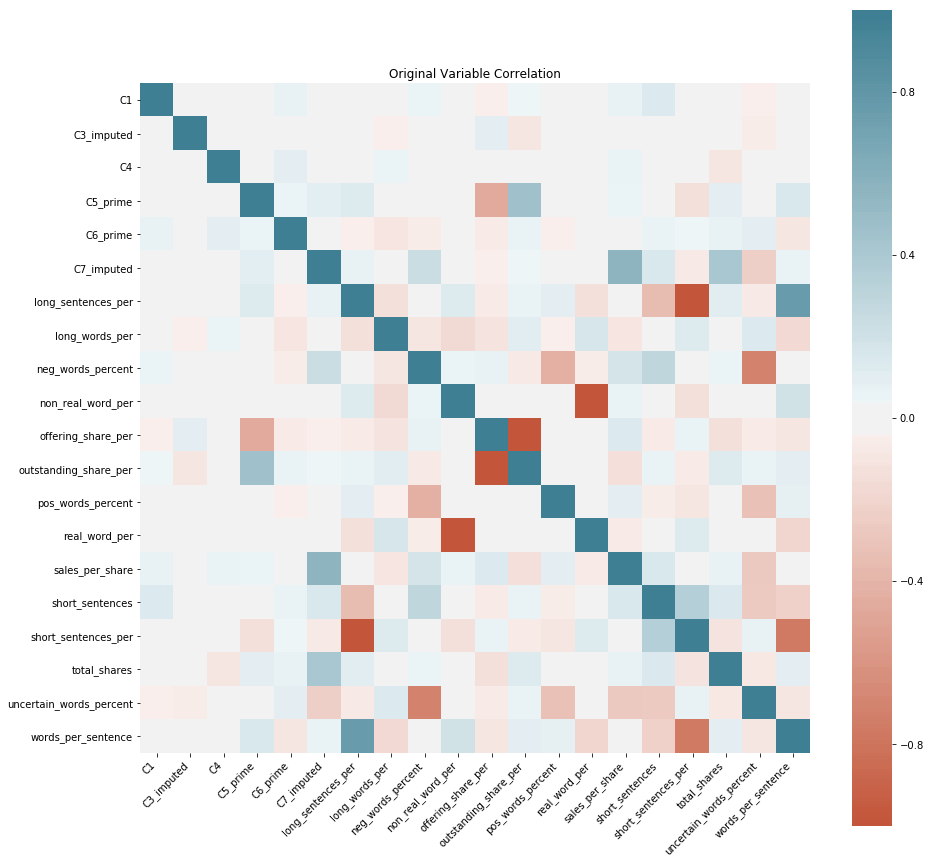

In [72]:
corr = cont_min_max_scaled[sorted([i for i in list(cont_min_max_scaled.columns) if 'standardized' not in i])].corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Original Variable Correlation')

We expect the diagonal to be a perfect correlation as it represents one field against itself. We also see others which are potentially correlated and need to be addressed. 

Some of these fields make intuitive sense as they were created off of the same input values. Initially both sets were retained as it was unknown which had the most predictive power. We can use this chart to pick subsets to be tested against each other later on.

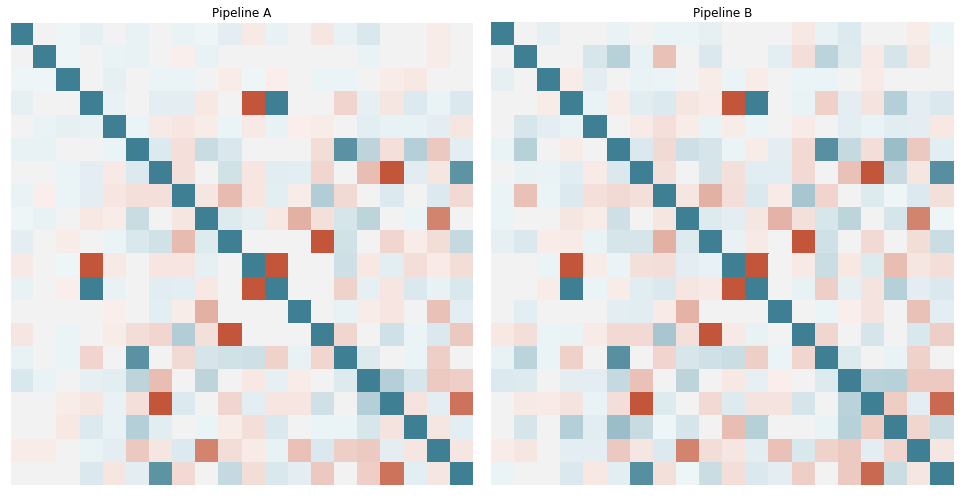

In [73]:
# NOTE that the dark version of Jupyterlab won't show the titles as the default is black...

corr = normalized_cont[sorted([i for i in list(normalized_cont.columns) if 'standardized' in i])].corr()
corr_alt = normalized_alt[sorted([i for i in list(normalized_alt.columns) if 'normalized_alt' in i])].corr()

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,15))


sns.heatmap(corr_alt, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=ax1,
           cbar = False)
sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=ax2,
            cbar = False)
ax1.set(yticks=[])
ax2.set(yticks=[])
ax1.set(xticks=[])
ax2.set(xticks=[])
ax1.set_title('Pipeline A')
ax2.set_title('Pipeline B')
fig.tight_layout(rect=[0, 0, .9, 1])
#fig.suptitle("Title centered above all subplots", fontsize=14)
plt.show()

The columns of both pipelines A and B were sorted to ensure they would be comparable when placed side by side. In this layout the similarity of both can be viewed easilly.

The areas of high correlation appear to be similar between pipelines. However, minor differences do occur, specifically with some additional correlation appearing in Pipeline B's results. These differences mean that features from both pipelines may be useful for modelling. 

In order to ensure that we identify highly correlated fields, we can keep track of all pairwise sets with a correlation value either below 0.5 or above 0.5 in their correlation values.

In [74]:
high_corrs = corr[((corr>0.5) | (corr < -0.5)) & (corr != 1)]
high_corrs_alt = corr_alt[((corr_alt>0.5) | (corr_alt < -0.5)) & (corr_alt != 1)]

In [75]:
high_corr_map = {}

for i in high_corrs.columns:
    val = list(high_corrs[i].dropna().index)
    if len(val) > 0:
        high_corr_map[i] = list(high_corrs[i].dropna().index)

In [76]:
high_corr_map_alt = {}

for i in high_corrs_alt.columns:
    val = list(high_corrs_alt[i].dropna().index)
    if len(val) > 0:
        high_corr_map_alt[i] = list(high_corrs_alt[i].dropna().index)

This mapping can be used to ensure we are not leveraging correlated features once feature selection and modelling begins.

# Step 9: Identify and remove redundunt information through Feature Selection
- Leverage correlation analysis
- RFE (recursive feature elimination) to select valuable items
- JointPlots against target

# Methodology 
- There will be a few different ways of representing the same information
    - Original Fields
    - Pipeline A
    - Pipeline B
- Take each of these in RFE to pick a "winner"
- Keep only the "winners" and use these in PCA

Only test fields intented for final results (nothing used in other features created, nothing relating to target variable)

In [77]:
def get_important_features_rfe(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = LogisticRegression(random_state=123)
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    

# Predict Y1

In [78]:
def test_evaluation(predictors_y1, y1):
    # lists for f1-score and AUC
    f1_score_lst = []
    auc_lst = []


    #loop to calculate f1 and auc scores and present averages after 10 runs
    for count in range (1,10):
        #Model building
        clf = LogisticRegression()
        X1_train, X1_test, y1_train, y1_test = train_test_split(predictors_y1, y1, test_size=0.2, random_state=123)
        clf.fit(X1_train, y1_train)

        y1_pred = clf.predict(X1_test)


        #10-fold cross validation
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        scoring = 'accuracy'
        results = model_selection.cross_val_score(clf, X1_train, y1_train, cv=kfold, scoring=scoring)




        #calculate f1-score and AUC

        clf_roc_auc = roc_auc_score(y1_test, y1_pred)
        f1_score_lst.append(precision_recall_fscore_support(y1_test, y1_pred, average='weighted')[2])
        auc_lst.append(clf_roc_auc)


    print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

    #result=logit_model.fit()
    confusion_matrix_y1 = confusion_matrix(y1_test, y1_pred)


    #print(result.summary())
    print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X1_test, y1_test)))

    print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

    print('Confusion Matrix for Logistic Regression Classfier:')
    print(confusion_matrix_y1)

    print('Classification Report for Logistic Regression Classfier:')
    print(classification_report(y1_test, y1_pred))
    
    try:
        imp = pd.DataFrame(zip(predictors_y1.columns, clf.coef_[0]))
    except Exception as e:
        imp = None
    return clf, imp

Initially all fields were used for prediction if they were normalized, with the exception of the variations of C6. This segmentation is necessary as C6 is formed off of the same fields used to create the target. 

A backwards-stepwise process was used to remove the features with the lowest absolute value for their coefficients. This proceded until the model score started to deteriorate with the removal of subsequent variables. This left us with the following model.

In [79]:
clf_norm, norm_imp = test_evaluation(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i 
                                               and 'C6' not in i and 
                                               i not in ['pos_words_percent_iqr_standardized_normalized',
                                                         'outstanding_share_per_iqr_standardized_normalized',
                                                         'long_sentences_per_iqr_standardized_normalized',
                                                         'short_sentences_iqr_standardized_normalized',
                                                         'offering_share_per_iqr_standardized_normalized',
                                                         'non_real_word_per_iqr_standardized_normalized',
                                                         'uncertain_words_percent_iqr_standardized_normalized',
                                                         #'words_per_sentence_iqr_standardized_normalized'
                                                        ]]], #+ [
# 'data_updated']], 
                target_df.Y1.values)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6376; AUC 0.6365 
Accuracy of classifier on test set: 0.64
10-fold cross validation average accuracy of classifier: 0.605
Confusion Matrix for Logistic Regression Classfier:
[[47 27]
 [21 37]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66        74
           1       0.58      0.64      0.61        58

    accuracy                           0.64       132
   macro avg       0.63      0.64      0.63       132
weighted avg       0.64      0.64      0.64       132



By leveraging the manual removal of features we are left with the following features as the current feature set. 

In [80]:
norm_imp.columns = ['field', 'imp']
norm_imp.sort_values(by = 'imp')

,field,imp
9,total_shares_iqr_standardized_normalized,-0.358097
10,sales_per_share_iqr_standardized_normalized,-0.319288
3,C3_imputed_iqr_standardized_normalized,-0.279956
6,short_sentences_per_iqr_standardized_normalized,-0.245762
2,C4_iqr_standardized_normalized,-0.226530
11,C5_prime_iqr_standardized_normalized,-0.192236
4,words_per_sentence_iqr_standardized_normalized,0.110621
1,C1_iqr_standardized_normalized,0.155663
7,long_words_per_iqr_standardized_normalized,0.221719
5,real_word_per_iqr_standardized_normalized,0.262329


However, in referring to the correlation analysis conducted above, we can check and see if any of the fields being used are highly correlated with each other. Ideally we would want to identify and remove these. 

In [81]:
for i in high_corr_map:
    if i in norm_imp.field.values:
        map_flds = [j for j in high_corr_map[i] if j in norm_imp.field.values]
        if len(map_flds) > 0:
            print(i, map_flds)

C7_imputed_iqr_standardized_normalized ['sales_per_share_iqr_standardized_normalized']
sales_per_share_iqr_standardized_normalized ['C7_imputed_iqr_standardized_normalized']
short_sentences_per_iqr_standardized_normalized ['words_per_sentence_iqr_standardized_normalized']
words_per_sentence_iqr_standardized_normalized ['short_sentences_per_iqr_standardized_normalized']


There are still some correlated features in the current feature set. In order to trim this we will remove those which have less impactful coefficients and retest our analysis. 

In [82]:
clf_norm, norm_imp = test_evaluation(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i 
                                               and 'C6' not in i and 
                                               i not in ['pos_words_percent_iqr_standardized_normalized',
                                                         'outstanding_share_per_iqr_standardized_normalized',
                                                         'long_sentences_per_iqr_standardized_normalized',
                                                         'short_sentences_iqr_standardized_normalized',
                                                         'offering_share_per_iqr_standardized_normalized',
                                                         'non_real_word_per_iqr_standardized_normalized',
                                                         'uncertain_words_percent_iqr_standardized_normalized',
                                                         'sales_per_share_iqr_standardized_normalized',
                                                         'words_per_sentence_iqr_standardized_normalized'
                                                        ]]], #+ [
# 'data_updated']], 
                target_df.Y1.values)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6223; AUC 0.6193 
Accuracy of classifier on test set: 0.62
10-fold cross validation average accuracy of classifier: 0.601
Confusion Matrix for Logistic Regression Classfier:
[[47 27]
 [23 35]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        74
           1       0.56      0.60      0.58        58

    accuracy                           0.62       132
   macro avg       0.62      0.62      0.62       132
weighted avg       0.62      0.62      0.62       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Although some of the features exhibit correlation with others used for prediction, cleansing our feature set actually leads to a worse prediction. As this is the case, other methods will need to be tested to try to further improve the model.

# Leverage RFE to improve results

RFE, recursive feature elimination, can be used against the set of features and order them in terms of percieved predictive power. Following this ordering we can try the best "n" features as seleced through RFE and see if our predicitons become better.

In [83]:
def get_important_features_rfe(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = LogisticRegression(random_state=123, max_iter = 1000)
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    

After some experimentaion we found that the top 10 features gave us the best results. This can be gathered through used of the RFE function created above and leveraged below.

In [84]:
feat_rfe = get_important_features_rfe(feat_mat[[i for i in list(feat_mat.columns) 
                                     if i not in ['I1', 'C6_prime','C6_prime_iqr_standardized','C6_prime_normalized','C6_prime_iqr_standardized_normalized']
                                               and 'iqr_standardized_normalized' in i]],
                          target_df.Y1.values, 10)

In [85]:
clf_rfe, rfe_imp = test_evaluation(feat_mat[[i for i in feat_rfe[0:10]]],
                target_df.Y1.values)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6376; AUC 0.6365 
Accuracy of classifier on test set: 0.64
10-fold cross validation average accuracy of classifier: 0.605
Confusion Matrix for Logistic Regression Classfier:
[[47 27]
 [21 37]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66        74
           1       0.58      0.64      0.61        58

    accuracy                           0.64       132
   macro avg       0.63      0.64      0.63       132
weighted avg       0.64      0.64      0.64       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [86]:
rfe_imp.columns = ['field', 'imp']
rfe_imp.sort_values(by = 'imp')

,field,imp
9,total_shares_iqr_standardized_normalized,-0.423452
8,short_sentences_per_iqr_standardized_normalized,-0.314324
7,sales_per_share_iqr_standardized_normalized,-0.282288
0,C3_imputed_iqr_standardized_normalized,-0.280437
1,C4_iqr_standardized_normalized,-0.198325
5,pos_words_percent_iqr_standardized_normalized,0.108857
3,long_words_per_iqr_standardized_normalized,0.230357
6,real_word_per_iqr_standardized_normalized,0.241009
4,neg_words_percent_iqr_standardized_normalized,0.409320
2,C7_imputed_iqr_standardized_normalized,0.449929


Although RFE offers us more information about the features, it does not have an immediate impact on the F1 score, or AUC values for the model. Although this is the case, the values given by RFE can be used alongside other feature engineering techniques to lead to model improvement. 

# PCA and RFE

Pricipal Component Analysis deals with the issue of high dimensionality, attempting to take a large feature space and compress it, without losing the underlying signal provided by the feature set as a whole. In our case, we will aim to retain 95% of the variance in the original data.

We only use PCA on the variables identified as the most important in RFE. We found that the top 11 features gave us the best results.

In [87]:
pca = PCA(0.95)

In [88]:
pca_transformed = pca.fit_transform(feat_mat[[i for i in feat_rfe[:11]]])

In [89]:
test_evaluation(pca_transformed, target_df.Y1.values)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6580; AUC 0.6512 
Accuracy of classifier on test set: 0.66
10-fold cross validation average accuracy of classifier: 0.574
Confusion Matrix for Logistic Regression Classfier:
[[53 21]
 [24 34]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70        74
           1       0.62      0.59      0.60        58

    accuracy                           0.66       132
   macro avg       0.65      0.65      0.65       132
weighted avg       0.66      0.66      0.66       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False), None)

By combining both RFE and PCA we have reached a model with exceeds our intial state. While there is still room for improvement, we have significantly advaced the predictive power of our model. 

In [101]:
feat_mat.to_csv('feat_mat.csv')

In [98]:
pca_df = pd.DataFrame(pca_transformed)
pca_df.columns = ['pca_' + str(i) for i in range(len(pca_df.columns))]
pca_df.to_pickle('pca_df_pred_Y1.pkl')

In order to make this reproducible the original feature matrix, as well as the pca-transformed values have been saved as 'feat_mat.csv' and 'pca_df_pred_Y1.pkl' respectively.

# Alternative models

Alternative models can also be leveraged for the Y1 prediction. In this case a Random Forest model will be leveraged using a similar feature space as above.

In [102]:
def get_important_features_rfe_rf(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = RandomForestClassifier()
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    

In [103]:
feat_rf_rfe = get_important_features_rfe_rf(feat_mat[[i for i in list(feat_mat.columns) 
                                     if i not in ['I1', 'C6_prime','C6_prime_iqr_standardized','C6_prime_normalized','C6_prime_iqr_standardized_normalized']
                                               and 'iqr_standardized_normalized' in i]],
                          target_df.Y1.values, 10)

In [104]:
def test_evaluation_rf(predictors_y1, y1):
    # lists for f1-score and AUC
    f1_score_lst = []
    auc_lst = []


    #loop to calculate f1 and auc scores and present averages after 10 runs
    for count in range (1,10):
        #Model building
        clf = RandomForestClassifier()
        X1_train, X1_test, y1_train, y1_test = train_test_split(predictors_y1, y1, test_size=0.2, random_state=123)
        clf.fit(X1_train, y1_train)

        y1_pred = clf.predict(X1_test)


        #10-fold cross validation
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        scoring = 'accuracy'
        results = model_selection.cross_val_score(clf, X1_train, y1_train, cv=kfold, scoring=scoring)




        #calculate f1-score and AUC

        clf_roc_auc = roc_auc_score(y1_test, y1_pred)
        f1_score_lst.append(precision_recall_fscore_support(y1_test, y1_pred, average='weighted')[2])
        auc_lst.append(clf_roc_auc)


    print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

    #result=logit_model.fit()
    confusion_matrix_y1 = confusion_matrix(y1_test, y1_pred)


    #print(result.summary())
    print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X1_test, y1_test)))

    print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

    print('Confusion Matrix for Logistic Regression Classfier:')
    print(confusion_matrix_y1)

    print('Classification Report for Logistic Regression Classfier:')
    print(classification_report(y1_test, y1_pred))

        
    imp = clf.feature_importances_
    return clf, imp

In [105]:
rf_clf, rf_imp = test_evaluation_rf(feat_mat[feat_rf_rfe], target_df.Y1.values)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6022; AUC 0.6038 
Accuracy of classifier on test set: 0.56
10-fold cross validation average accuracy of classifier: 0.599
Confusion Matrix for Logistic Regression Classfier:
[[41 33]
 [25 33]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.62      0.55      0.59        74
           1       0.50      0.57      0.53        58

    accuracy                           0.56       132
   macro avg       0.56      0.56      0.56       132
weighted avg       0.57      0.56      0.56       132



In [106]:
rf_feat_importance = pd.DataFrame(zip(feat_rf_rfe, rf_imp))
rf_feat_importance.columns = ['field','importance']
rf_feat_importance.sort_values('importance')

,field,importance
18,C5_prime_iqr_standardized_normalized,0.039861
16,offering_share_per_iqr_standardized_normalized,0.040458
15,C1_iqr_standardized_normalized,0.043091
4,outstanding_share_per_iqr_standardized_normalized,0.043801
14,pos_words_percent_iqr_standardized_normalized,0.048071
6,sales_per_share_iqr_standardized_normalized,0.048163
10,C7_imputed_iqr_standardized_normalized,0.048966
12,total_shares_iqr_standardized_normalized,0.049868
8,short_sentences_per_iqr_standardized_normalized,0.051206
7,short_sentences_iqr_standardized_normalized,0.051401


Initial results do not meet the bar set by our initial Logistic Regression. We can replicate the steps which got us the best Logistic Regression model and see if we see similar results in the Random Forest.

In [107]:
pca_rf = PCA(0.95)
pca_transformed_rf = pca_rf.fit_transform(feat_mat[[i for i in feat_rf_rfe[:11]]])

In [108]:
test_evaluation_rf(pca_transformed_rf, target_df.Y1.values)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.5291; AUC 0.5314 
Accuracy of classifier on test set: 0.52
10-fold cross validation average accuracy of classifier: 0.605
Confusion Matrix for Logistic Regression Classfier:
[[38 36]
 [27 31]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.58      0.51      0.55        74
           1       0.46      0.53      0.50        58

    accuracy                           0.52       132
   macro avg       0.52      0.52      0.52       132
weighted avg       0.53      0.52      0.52       132



(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 array([0.10366602, 0.12019043, 0.10172554, 0.12933353, 0.10210335,
        0.15049575, 0.10482758, 0.09583657, 0.09182122]))

Interestingly enough, the same strategy with led to higher predictive power with the initial Logistic Regression actually made the Random Forest model its worst iteration thusfar. At this point the random forest is hardly better than a random guess at the target value. As this is the case, we will stick with the Logistic Regression model.

# Predict Y2

We will leverage a similar strategy for Y2 predictions, creating an evaluation function and leveraging stepwise feature elimination, RFE, PCA, and different models for predictions.

In [165]:
def test_evaluation_y2(predictors_y2, y2):
    # lists for f1-score and AUC
    f1_score_lst = []
    auc_lst = []


    #loop to calculate f1 and auc scores and present averages after 10 runs
    for count in range (1,10):
        #Model building
        clf1 = LogisticRegression()


        # Splitting data into testing and training
        X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)

        # Begin oversampling
        #oversample = pd.concat([X2_train,y2_train],axis=1)
        oversample = X2_train.copy()
        oversample['Y2'] = y2_train.values
        max_size = oversample['Y2'].value_counts().max()
        lst = [oversample]
        for class_index, group in oversample.groupby('Y2'):
            lst.append(group.sample(max_size-len(group), replace=True))
        X2_train = pd.concat(lst)
        y2_train=pd.DataFrame.copy(X2_train['Y2'])
        del X2_train['Y2']

        # fitting model on oversampled data
        clf1.fit(X2_train, y2_train)

        y2_pred = clf1.predict(X2_test)


        #10-fold cross validation
        kfold = model_selection.KFold(n_splits=10)
        scoring = 'accuracy'
        results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)

        #calculate f1-score and AUC

        clf1_roc_auc = roc_auc_score(y2_test, y2_pred)


        #calculate average f1-score and AUC
        f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
        auc_lst.append(clf1_roc_auc)


    print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

    confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


    print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

    print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

    print('Confusion Matrix for Classfier:')
    print(confusion_matrix_y2)

    print('Classification Report for Classfier:')
    print(classification_report(y2_test, y2_pred))

    imp = pd.DataFrame(zip(predictors_y2.columns, clf1.coef_[0]))
    imp.columns = ['field','importance']
    imp.sort_values('importance', inplace = True)
    return clf1, imp


In [186]:
y2 = target_df.Y2

feat_rfe = get_important_features_rfe(feat_mat[[i for i in list(feat_mat.columns) 
                                     if i != 'I1' and 
                                                (('iqr_standardized_normalized' in i) or 
                                                 ('normalized_alt' in i))]],
                                      y2, 10)

predictors_y2 = feat_mat[feat_rfe[:10]]

In [187]:
clf_y2, imp = test_evaluation_y2(predictors_y2, y2)

F1 0.6665; AUC 0.6184 
Accuracy of classifier on test set: 0.652
10-fold cross validation average accuracy of clf1: 0.595
Confusion Matrix for Classfier:
[[19 14]
 [32 67]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.37      0.58      0.45        33
           1       0.83      0.68      0.74        99

    accuracy                           0.65       132
   macro avg       0.60      0.63      0.60       132
weighted avg       0.71      0.65      0.67       132



In [188]:
imp

,field,importance
2,C4_normalized_alt,-1.362968
0,C3_imputed_normalized_alt,-0.415199
5,neg_words_percent_normalized_alt,-0.137101
9,short_sentences_per_normalized_alt,-0.083187
8,short_sentences_per_iqr_standardized_normalized,0.110860
7,outstanding_share_per_normalized_alt,0.301164
3,C5_prime_normalized_alt,0.459802
4,C6_prime_iqr_standardized_normalized,0.515286
6,offering_share_per_iqr_standardized_normalized,0.526936
1,C4_iqr_standardized_normalized,1.594478


We see that the initial modelling leads to a middling result for the F1 and AUC score. Additionally, this model contains correlated variables and a mix from Pipeline A and Pipeline B for predictions. However, removing correlated variables or sticking to only a single pipeline did not lead to an improvement in results. Similarly, PCA did not seem to make as much of an impact in this model as it did for predicting Y1. As this is the case, alternative modelling results were necessary. 

# XGBoost Model for Y2 Predictions

A subset of features can be taken. These come as the non-correlated features selected from PCA against the categorical fields, Pipeline A, and Pipeline B.

In [192]:
#predictors_y2 = feat_mat[[i for i in feat_mat.columns if 'I1' not in i]]
predictors_y2 = feat_mat[['industry_bin__Other','short_sentences_iqr_standardized','C3_imputed_normalized',
                'total_shares_iqr_standardized','outstanding_share_per_iqr_standardized_normalized',
                'C2','offering_share_per_iqr_standardized_normalized','C5_prime_iqr_standardized_normalized',
                'C6_prime_iqr_standardized_normalized','C7_imputed']]

The data is split the same as it was for other models. However, due to class imbalance oversampling is leveraged to have an equal number of targets which are 0 and which are 1.

In [193]:
# Splitting data into testing and training
X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)

# Begin oversampling
#oversample = pd.concat([X2_train,y2_train],axis=1)
oversample = X2_train.copy()
oversample['Y2'] = y2_train.values
max_size = oversample['Y2'].value_counts().max()
lst = [oversample]
for class_index, group in oversample.groupby('Y2'):
    lst.append(group.sample(max_size-len(group), replace=True))
X2_train = pd.concat(lst)
y2_train=pd.DataFrame.copy(X2_train['Y2'])
del X2_train['Y2']

A randomized parameter sweep is used to tune the model. This is a useful substitute for more time and resource intensive grid searches. We set a grid of parameters and set the optimization for AUC. We also set a low cross validation due to the limited training data, and can then compare results to previous attempts. 

In [194]:
parameters = {
                'booster': ['gbtree','dart'],
                'verbosity': [2],
                'learning_rate': [0.01,0.05,0.1],
#                 "n_estimators":[75,150,200],
                'gamma': [0,1,5],
                'max_depth': [3,4,5],
                'scale_pos_weight': [1],
                'subsample': [0.3, 0.4],
                'colsample_bytree': [0.2,0.3,0.5],
                'lambda': [0,0.33,0.66,1]
            }

eval_set = [(X2_train, y2_train), (X2_test, y2_test)]
eval_metric = ["auc"]

xgb_test = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, eval_metric=eval_metric, eval_set=eval_set)

folds = 2
param_comb = 500

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 6)

random_search = RandomizedSearchCV(xgb_test, param_distributions=parameters, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=-4, cv=skf.split(X2_train,y2_train), verbose=3, random_state=6 )

random_search.fit(X2_train, y2_train)


Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=-4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-4)]: Done 178 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-4)]: Done 498 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-4)]: Done 946 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    9.2s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f2f6ce1e620>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric=['auc'],
                                           eval_set=[(     industry_bin__Other  short_sentences_iqr_standardized  \
303                    0                          0.320988   
75                     0                          0.308642   
267                    0                          0.460905   
491                    0                          0.399177   
101                    0                          0.386831   
..                   ...                               ....
                   iid='deprecated', n_iter=500, n_jobs=-4,
          

In [195]:
print(classification_report(y_pred=random_search.best_estimator_.predict(X2_test), y_true=y2_test))

              precision    recall  f1-score   support

           0       0.40      0.42      0.41        33
           1       0.80      0.79      0.80        99

    accuracy                           0.70       132
   macro avg       0.60      0.61      0.60       132
weighted avg       0.70      0.70      0.70       132



In [197]:
print(classification_report(y_pred=random_search.best_estimator_.predict(X2_train), y_true=y2_train))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       362
           1       0.97      0.95      0.96       362

    accuracy                           0.96       724
   macro avg       0.96      0.96      0.96       724
weighted avg       0.96      0.96      0.96       724



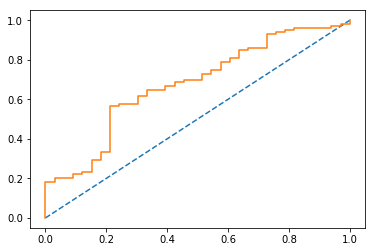

0.6752372206917662


In [196]:
xgb_proba = random_search.best_estimator_.predict_proba(X2_test)

probs = xgb_proba[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y2_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# show the plot
plt.show()
auc = roc_auc_score(y2_test, probs)
print(auc)

Through use of the Random Parameter Sweep and the XGBoost model we are able to get to our best predictions. F1 scores range between 0.70 and 0.75, while AUC consistantly ranges between 0.65 and 0.70.

Although powerful, we must be careful when leveraging this model as it nearly fits the training data perfectly despite the use of the eval set to try to reduce overfitting. However, despite the potential for overfitting we also see good performance against the test set, signaling that our model is sound in making predictions against new data as well as that which it was trained on.

For reproducibility, the model and features have been saved below. The features can be applied to the 'feat_mat.csv' file, or the subset can be loaded from the 'predictors_y2.pkl' file. All target values can be loaded from the 'target_df.csv' file.

In [200]:
pickle.dump([list(predictors_y2.columns),random_search.best_estimator_], open('y2_xgb_3_1_20', 'wb'))

In [201]:
predictors_y2.to_pickle('predictors_y2.pkl')